Found 287 images belonging to 5 classes.
Found 113 images belonging to 5 classes.
Found 172 images belonging to 5 classes.
Epoch 1/50


/Users/mananmathur/anaconda3/envs/oct_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.1861 - loss: 2.8680
Epoch 1: val_loss improved from inf to 1.61080, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/models/mobilenet_OCTID_best.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 286ms/step - accuracy: 0.1878 - loss: 2.8492 - val_accuracy: 0.4159 - val_loss: 1.6108 - learning_rate: 1.0000e-04
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3283 - loss: 1.9245
Epoch 2: val_loss improved from 1.61080 to 1.36414, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/models/mobilenet_OCTID_best.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.3284 - loss: 1.9271 - val_accuracy: 0.4956 - val_loss: 1.3641 - learning_rate: 1.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4262 - loss: 1.6553
Epoch 3: val_loss improved from 1.36414 to 1.17525, saving model to /Users/manan

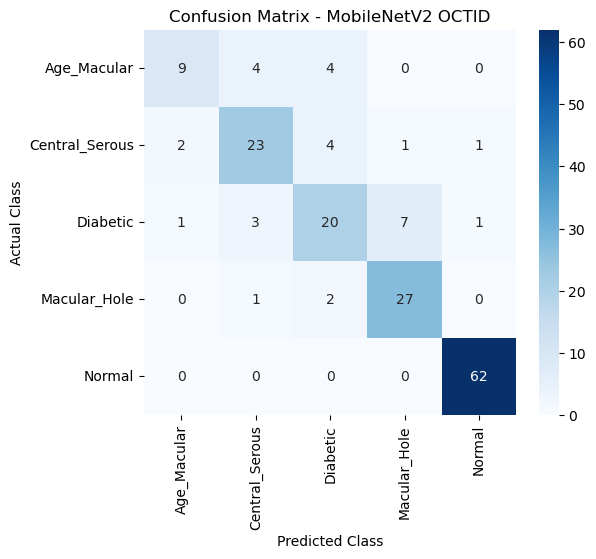

Classification Report:
                 precision    recall  f1-score   support

   Age_Macular       0.75      0.53      0.62        17
Central_Serous       0.74      0.74      0.74        31
      Diabetic       0.67      0.62      0.65        32
  Macular_Hole       0.77      0.90      0.83        30
        Normal       0.97      1.00      0.98        62

      accuracy                           0.82       172
     macro avg       0.78      0.76      0.76       172
  weighted avg       0.82      0.82      0.81       172

✅ Results saved to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/results/mobilenet_OCTID.xlsx


In [2]:
# DATASET = OCTID
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import classification_report, confusion_matrix

# Disable GPU (if needed)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Paths and Constants
dataset_path = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/OCTID"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "test")

image_size = 224  # MobileNetV2 requires 224x224 images
batch_size = 16
num_classes = 5  # Multi-class classification

# Data Generators
datagen = ImageDataGenerator(rescale=1.0 / 255.0)
train_generator = datagen.flow_from_directory(train_dir, target_size=(image_size, image_size), batch_size=batch_size, class_mode="categorical")
val_generator = datagen.flow_from_directory(val_dir, target_size=(image_size, image_size), batch_size=batch_size, class_mode="categorical")
test_generator = datagen.flow_from_directory(test_dir, target_size=(image_size, image_size), batch_size=batch_size, class_mode="categorical", shuffle=False)

# Load MobileNetV2 Model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
base_model.trainable = False  # Freeze base model initially

# Define Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks
model_save_path = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/models/mobilenet_OCTID_best.keras"
checkpoint = ModelCheckpoint(model_save_path, monitor="val_loss", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)
csv_logger = CSVLogger("/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/training/mobilenet_OCTID.csv", append=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, verbose=1, min_lr=1e-6)

# Train Model
history = model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[checkpoint, early_stopping, csv_logger, reduce_lr], verbose=1)

# Load Best Model
model = load_model(model_save_path)

# Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate Predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix - MobileNetV2 OCTID")
plt.show()

# Classification Report
report = classification_report(true_labels, predicted_classes, target_names=train_generator.class_indices.keys(), output_dict=True)
print("Classification Report:\n", classification_report(true_labels, predicted_classes, target_names=train_generator.class_indices.keys()))

# Save Results to Excel
excel_file = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/results/mobilenet_OCTID.xlsx"
results_df = pd.DataFrame({
    "Dataset": ["OCTID"],
    "Model": ["MobileNetV2"],
    "Test Accuracy": [test_accuracy],
    "Test Loss": [test_loss],
    "Precision": [report["weighted avg"]["precision"]],
    "Recall": [report["weighted avg"]["recall"]],
    "F1-Score": [report["weighted avg"]["f1-score"]]
})

try:
    if os.path.exists(excel_file):
        existing_df = pd.read_excel(excel_file)
        results_df = pd.concat([existing_df, results_df], ignore_index=True)
except FileNotFoundError:
    pass  # If the file does not exist, it will be created

results_df.to_excel(excel_file, index=False)
print(f"✅ Results saved to {excel_file}")


Found 1095 images belonging to 2 classes.
Found 451 images belonging to 2 classes.
Found 644 images belonging to 2 classes.


2025-03-22 18:49:17.595472: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-03-22 18:49:17.595509: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-22 18:49:17.595514: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-22 18:49:17.595951: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-22 18:49:17.595970: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/Users/mananmathur/anaconda3/envs/oct_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


2025-03-22 18:49:19.629847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6680 - loss: 0.7172
Epoch 1: val_loss improved from inf to 0.32212, saving model to logs/models/mobilenetv2_OCTDL_best.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 196ms/step - accuracy: 0.6691 - loss: 0.7156 - val_accuracy: 0.8160 - val_loss: 0.3221 - learning_rate: 1.0000e-04
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8081 - loss: 0.3931
Epoch 2: val_loss improved from 0.32212 to 0.25655, saving model to logs/models/mobilenetv2_OCTDL_best.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.8084 - loss: 0.3926 - val_accuracy: 0.9047 - val_loss: 0.2565 - learning_rate: 1.0000e-04
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8388 - loss: 0.3541
Epoch 3: val_loss improved from 0.25655 to 0.25552, saving model to logs/models/mobilenetv2_OCTDL_best.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 0.8389 - loss: 0.3538 - val_accuracy: 0.9047 - val_loss: 0.2555 - learning_rate: 1.0

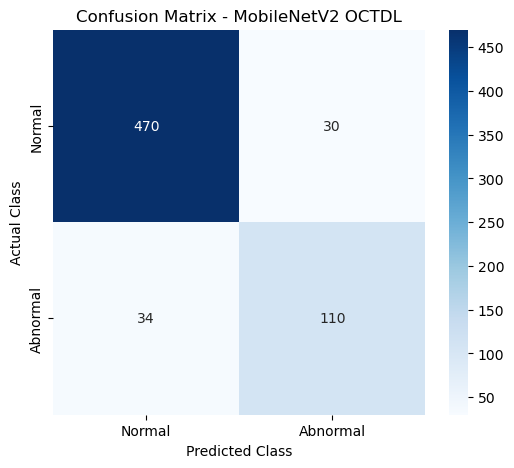

Classification Report:
               precision    recall  f1-score   support

      Normal       0.93      0.94      0.94       500
    Abnormal       0.79      0.76      0.77       144

    accuracy                           0.90       644
   macro avg       0.86      0.85      0.86       644
weighted avg       0.90      0.90      0.90       644

✅ Results saved to logs/results/mobilenetv2_OCTDL.xlsx


In [1]:
# DATASET = OCTDL
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import confusion_matrix, classification_report

# Disable GPU if needed
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Paths and Constants
dataset_path = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/OCTDL"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "test")

image_size = 224
batch_size = 16
num_classes = 2  # Binary Classification

# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0, rotation_range=30, zoom_range=0.1, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Data Loaders
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(image_size, image_size), batch_size=batch_size, class_mode="binary", shuffle=True)
val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=(image_size, image_size), batch_size=batch_size, class_mode="binary", shuffle=True)
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=(image_size, image_size), batch_size=batch_size, class_mode="binary", shuffle=False)

# Load MobileNetV2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
base_model.trainable = False  # Freeze initially

# Define Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# Callbacks
model_save_path = "logs/models/mobilenetv2_OCTDL_best.keras"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
csv_logger = CSVLogger("logs/training/mobilenetv2_OCTDL.csv", append=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, verbose=1, min_lr=1e-6)

# Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Reduced for efficiency
    callbacks=[checkpoint, early_stopping, csv_logger, reduce_lr],
    verbose=1
)

# Load Best Model
model = load_model(model_save_path)

# Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate Predictions
predictions = model.predict(test_generator)
binary_predictions = (predictions > 0.5).astype(int).flatten()
true_labels = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(true_labels, binary_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix - MobileNetV2 OCTDL")
plt.show()

# Classification Report
report = classification_report(true_labels, binary_predictions, target_names=["Normal", "Abnormal"], output_dict=True)
print("Classification Report:\n", classification_report(true_labels, binary_predictions, target_names=["Normal", "Abnormal"]))

# Save Results to Excel
excel_file = "logs/results/mobilenetv2_OCTDL.xlsx"
results_df = pd.DataFrame({
    "Dataset": ["OCTDL"],
    "Model": ["MobileNetV2"],
    "Test Accuracy": [test_accuracy],
    "Test Loss": [test_loss],
    "Precision": [report["weighted avg"]["precision"]],
    "Recall": [report["weighted avg"]["recall"]],
    "F1-Score": [report["weighted avg"]["f1-score"]]
})

try:
    if os.path.exists(excel_file):
        existing_df = pd.read_excel(excel_file)
        results_df = pd.concat([existing_df, results_df], ignore_index=True)
except FileNotFoundError:
    pass  # If the file does not exist, it will be created

results_df.to_excel(excel_file, index=False)
print(f"✅ Results saved to {excel_file}")
